## Data Cleaning

In [179]:
import csv, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [180]:
companies = pd.read_csv("https://docs.google.com/uc?export=download&id=1fla_FjzVKVITNCgOxyx5XhzCXu9qnkSS",encoding = 'unicode_escape')
rounds2 = pd.read_csv("https://docs.google.com/uc?export=download&id=1D0y096SKAs6JU6e3GNvEAOxHnYgLuz1L",encoding = 'unicode_escape')

In [181]:
# import chardet ## to detect character encoding with confidence
# with open("/home/mohd/Downloads/ms/companies.csv",'rb') as rawdata:
#     result=chardet.detect(rawdata.read(66366))
#     print(result)

There are encoding issues in the files. Loading with unicode_escape encoding resolves them. Encoding with engine=python gives similar results.

In [182]:
companies.head()



,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


In [183]:
rounds2.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,"10,000,000.00"
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,"700,000.00"
3,/ORGANIZATION/-THE-ONE-OF-THEM-INC-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,"3,406,878.00"
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,"2,000,000.00"


company_permalink is the reference key for companies.permalink which visibly needs to be lower cased.

In [184]:
companies.permalink = companies.permalink.str.lower()
rounds2.company_permalink = rounds2.company_permalink.str.lower()

In [185]:
companies.permalink.dropna().unique().size

66368

In [186]:
rounds2.company_permalink.dropna().unique().size

66370

This hints to some companies present referenced in rounds file but not present in main companies file. Lets check those...

In [187]:
rounds2_unref = rounds2[~rounds2.company_permalink.isin(companies.permalink)]
rounds2_unref

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
29597,/organization/e-cãbica,/funding-round/8491f74869e4fe8ba9c378394f8fbdea,seed,NaN,01-02-2015,nan
31863,/organization/energystone-games-çµç³æ¸¸æ,/funding-round/b89553f3d2279c5683ae93f45a21cfe0,seed,NaN,09-08-2014,nan
45176,/organization/huizuche-com-æ ç§ÿè½¦,/funding-round/8f8a32dbeeb0f831a78702f83af78a36,seed,NaN,18-09-2014,nan
58473,/organization/magnet-tech-ç£ç³ç§æ,/funding-round/8fc91fbb32bc95e97f151dd0cb4166bf,seed,NaN,16-08-2014,"1,625,585.00"
101036,/organization/tipcat-interactive-æ²èÿä¿¡æ¯ç...,/funding-round/41005928a1439cb2d706a43cb661f60f,seed,NaN,06-09-2010,nan
109969,/organization/weiche-tech-åè½¦ç§æ,/funding-round/f74e457f838b81fa0b29649740f186d8,venture,A,06-09-2015,nan
113839,/organization/zengame-ç¦ æ¸¸ç§æ,/funding-round/6ba28fb4f3eadf5a9c6c81bc5dde6cdf,seed,NaN,17-07-2010,nan


In [188]:
companies_unref = companies[~companies.permalink.isin(rounds2.company_permalink)]
companies_unref

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
16827,/organization/e-cãbica,E CÃBICA,NaN,NaN,operating,NaN,NaN,NaN,NaN,NaN
18197,/organization/energystone-games-çµçÿ³æ¸¸æ,EnergyStone Games çµç³æ¸¸æ,NaN,Mobile Games|Online Gaming,closed,NaN,NaN,NaN,NaN,06-01-2013
26139,/organization/huizuche-com-æ ç§è½¦,Huizuche.com æ ç§è½¦,http://huizuche.com,NaN,closed,NaN,NaN,NaN,NaN,24-04-2014
58344,/organization/tipcat-interactive-æ²èä¿¡æ¯ç...,TipCat Interactive æ²èä¿¡æ¯ç§æ,http://www.tipcat.com,Mobile Games|Online Gaming,closed,NaN,NaN,NaN,NaN,18-08-2009
65778,/organization/zengame-ç¦ æ¸¸ç§æ,ZenGame ç¦ æ¸¸ç§æ,http://www.zen-game.com,Internet|Mobile Games|Online Gaming,closed,NaN,NaN,NaN,NaN,17-07-2010


Being less then 1%, it makes sense to drop these rows as they seem to be have some encoding issues. 
Lets proceed for now, without dropping them, since it wont make any significant difference on our aggregate metrics.

In [189]:
#rounds2 = rounds2[rounds2.company_permalink.isin(companies.permalink)]

In [190]:
companies.info()
rounds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   permalink      66368 non-null  object
 1   name           66367 non-null  object
 2   homepage_url   61310 non-null  object
 3   category_list  63220 non-null  object
 4   status         66368 non-null  object
 5   country_code   59410 non-null  object
 6   state_code     57821 non-null  object
 7   region         58338 non-null  object
 8   city           58340 non-null  object
 9   founded_at     51147 non-null  object
dtypes: object(10)
memory usage: 5.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   company_permalink        114949 non-null  object 
 1   funding_round_permalink  114949 non-null  object 
 2  

companies.founded_at and rounds.funded_at are of object type. They should be converted to datetime type, but since they are not relevant to the problem statement, lets leave this type casting.

In [191]:
round(100*companies.isna().sum()/len(companies.index),2)

permalink        0.00
name             0.00
homepage_url     7.62
category_list    4.74
status           0.00
country_code    10.48
state_code      12.88
region          12.10
city            12.10
founded_at      22.93
dtype: float64

In [192]:
rounds2.isna().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
dtype: int64

In [193]:
round(100*rounds2.isna().sum()/len(rounds2.index),2)

company_permalink          0.00
funding_round_permalink    0.00
funding_round_type         0.00
funding_round_code        72.91
funded_at                  0.00
raised_amount_usd         17.39
dtype: float64

A lot of NAs especially in potentially important columns i.e companies.category_list, companies.country_code, rounds.raised_amount_usd . 
Since the common column, company_permalink has no NAs lets proceed for joining data. 
Also, imputing raised_amount_usd and category_list might add a bias in our analysis, hence leaving impution for now.

In [194]:
pd.options.display.float_format = "{:,.2f}".format  ## readable numerical

In [195]:
master_frame = pd.merge(companies,rounds2, how='right', left_on='permalink', right_on='company_permalink')
master_frame

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,"10,000,000.00"
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan
2,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,"700,000.00"
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,"3,406,878.00"
4,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,"2,000,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114944,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Advertising|Mobile|Web Development|Wireless,operating,HRV,15,Split,Split,13-05-2012,/organization/zzzzapp-com,/funding-round/8f6d25b8ee4199e586484d817bceda05,convertible_note,NaN,01-03-2014,"41,313.00"
114945,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Advertising|Mobile|Web Development|Wireless,operating,HRV,15,Split,Split,13-05-2012,/organization/zzzzapp-com,/funding-round/ff1aa06ed5da186c84f101549035d4ae,seed,NaN,01-05-2013,"32,842.00"
114946,/organization/ãeron,ÃERON,http://www.aeron.hu/,NaN,operating,NaN,NaN,NaN,NaN,01-01-2011,/organization/ãeron,/funding-round/59f4dce44723b794f21ded3daed6e4fe,venture,A,01-08-2014,nan
114947,/organization/ãasys-2,Ãasys,http://www.oasys.io/,Consumer Electronics|Internet of Things|Teleco...,operating,USA,CA,SF Bay Area,San Francisco,01-01-2014,/organization/ãasys-2,/funding-round/35f09d0794651719b02bbfd859ba9ff5,seed,NaN,01-01-2015,"18,192.00"


Right join towards rounds table since we require to add companies information into rounds information. The joined dataset contains 114949 rows.

##Funding Type Analysis

Considering the four funding types and dropping NAs 

In [196]:
master_frameG = master_frame[["funding_round_type","raised_amount_usd"]][master_frame["funding_round_type"].isin( ["angel","private_equity","seed","venture"])].dropna()
grouped = master_frameG.groupby(["funding_round_type"])
grouped.describe()

raised_amount_usd  ...                  
                               count  ...               max
funding_round_type                    ...                  
angel                       4,860.00  ...    494,511,992.00
private_equity              1,936.00  ...  4,745,460,219.00
seed                       23,603.00  ...    200,000,000.00
venture                    50,228.00  ... 17,600,000,000.00

[4 rows x 8 columns]

There are outliers, eg: 0 , and IQR and std also suggest median to be used as representative value. 

Lets check if removing 2% quantiles affect these values

In [197]:
low = .02
high = .98
quant_df = grouped.quantile([low, high])
master_frameG2 = master_frameG[master_frameG.apply(lambda x: (x["raised_amount_usd"] <= quant_df.loc[x["funding_round_type"], high]) & (x["raised_amount_usd"] >= quant_df.loc[x["funding_round_type"], low]) , axis = 1 )["raised_amount_usd"]]
groupedG2 = master_frameG2.groupby(["funding_round_type"])
groupedG2.describe()

raised_amount_usd                ...                             
                               count          mean  ...           75%            max
funding_round_type                                  ...                             
angel                       4,685.00    661,230.17  ...    940,000.00   4,500,000.00
private_equity              1,868.00 55,916,472.02  ... 75,000,000.00 500,000,000.00
seed                       22,701.00    598,234.00  ...    950,000.00   3,536,085.00
venture                    48,231.00  8,839,723.60  ... 11,500,000.00  60,000,000.00

[4 rows x 8 columns]

No change in medians, but std is slightly more stable

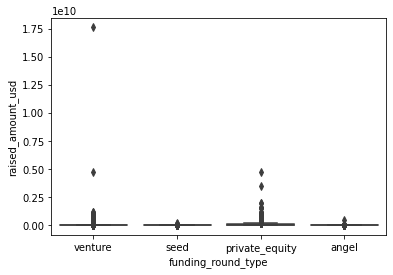

In [198]:
sns.boxplot(data=master_frameG, x = "funding_round_type", y = "raised_amount_usd")
plt.show()

Hiding outliers

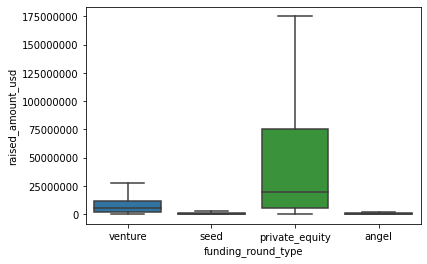

In [199]:
# plt.figure(figsize=[9,7])
sns.boxplot(data=master_frameG, x = "funding_round_type", y = "raised_amount_usd",showfliers=False)
plt.ticklabel_format(style='plain', axis='y')  ## non-scientific y-axis
plt.show()

Lets plot after removing 25% quantiles

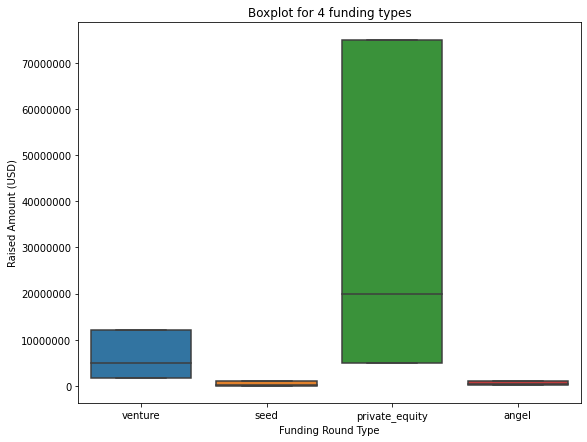

In [200]:
plt.figure(figsize=[9,7])
ax = sns.boxplot(data=master_frameG, x = "funding_round_type", y = "raised_amount_usd",showfliers=False, whis=[25, 75])
plt.ticklabel_format(style='plain', axis='y')  
ax.set(xlabel = "Funding Round Type", ylabel='Raised Amount (USD)')

plt.title("Boxplot for 4 funding types")
plt.show()

Change to log scale

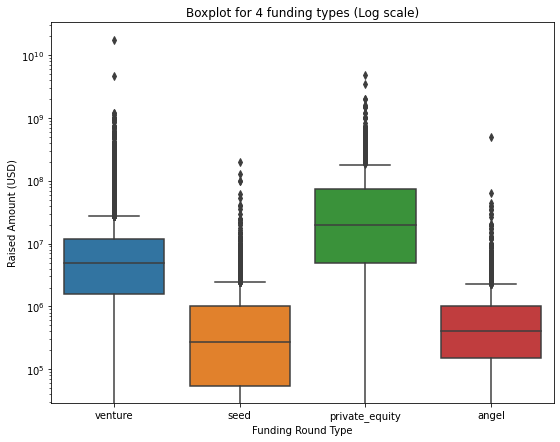

In [201]:
plt.figure(figsize=[9,7])
ax = sns.boxplot(data=master_frameG, x = "funding_round_type", y = "raised_amount_usd")
plt.ticklabel_format(style='plain', axis='y')  
ax.set(xlabel = "Funding Round Type", ylabel='Raised Amount (USD)')

plt.yscale("log")
plt.title("Boxplot for 4 funding types (Log scale)")
plt.show()

This shows venture type funding suits Spark funds.

##Country analysis

Lets filter venture type funding and group by country code to get top 9 heavily invested countries

In [202]:
groupedtop9 = master_frame[["country_code","raised_amount_usd"]][master_frame["funding_round_type"]=="venture"].dropna().groupby(["country_code"])
top9 = groupedtop9.agg([np.sum, np.mean, np.std, "count"])["raised_amount_usd"].sort_values(["sum"],ascending=False).iloc[0:9,:]
top9

,sum,mean,std,count
country_code,,,,
USA,"422,510,842,796.00","11,691,271.00","99,515,071.88",36139
CHN,"39,835,418,773.00","25,470,216.61","65,692,989.71",1564
GBR,"20,245,627,416.00","9,851,886.82","27,629,966.06",2055
IND,"14,391,858,718.00","17,465,847.96","52,553,965.59",824
CAN,"9,583,332,317.00","7,630,041.65","11,623,451.29",1256
FRA,"7,259,536,732.00","7,916,615.85","20,906,397.60",917
ISR,"6,907,514,579.00","8,677,782.13","10,861,274.83",796
DEU,"6,346,959,822.00","11,374,479.97","18,607,789.38",558
JPN,"3,363,676,611.00","12,276,192.01","26,308,857.70",274


China not being in english speaking country [list](https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language), we take USA, Great Britain and India

In [203]:
## OR using pivot tables
# asd = master_frame[["country_code","raised_amount_usd"]][master_frame["funding_round_type"]=="venture"].dropna()
# pd.pivot_table(asd, index = "country_code", values = "raised_amount_usd",aggfunc=[np.sum,len])["sum"].sort_values(["raised_amount_usd"],ascending=False).iloc[0:9,:]

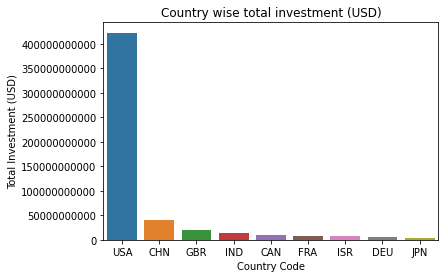

In [204]:
top9["country_code"] = top9.index
ax = sns.barplot(data=top9,x="country_code",y="sum")
plt.ticklabel_format(style='plain', axis='y')  
ax.set(xlabel = "Country Code", ylabel='Total Investment (USD)')
plt.title("Country wise total investment (USD)")
plt.show()

## Sector Analysis

In [205]:
mapping = pd.read_csv("https://docs.google.com/uc?export=download&id=1Ebsa6nyKseIJymf3vNM6kh4C6oicgfex",encoding = 'unicode_escape')
mapping

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
683,Wholesale,0,0,0,0,0,0,0,1,0
684,Wine And Spirits,0,0,0,1,0,0,0,0,0
685,Wireless,0,0,0,1,0,0,0,0,0
686,Women,0,0,0,0,0,0,0,1,0


First row needs to be removed.



In [206]:
mapping = mapping.dropna()
mapping.sum(axis=0)

category_list                              3D3D Printing3D TechnologyAccountingActive Lif...
Automotive & Sports                                                                       22
Blanks                                                                                     0
Cleantech / Semiconductors                                                                53
Entertainment                                                                             89
Health                                                                                    63
Manufacturing                                                                             40
News, Search and Messaging                                                                72
Others                                                                                   195
Social, Finance, Analytics, Advertising                                                  153
dtype: object

 Blanks Column is irrelevant.

In [207]:
mapping

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1
5,Active Lifestyle,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
683,Wholesale,0,0,0,0,0,0,0,1,0
684,Wine And Spirits,0,0,0,1,0,0,0,0,0
685,Wireless,0,0,0,1,0,0,0,0,0
686,Women,0,0,0,0,0,0,0,1,0


Convert Long to wide

In [208]:
mapping["category"] =  mapping.iloc[:,1:10].idxmax(1) ## Or use melt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [209]:
mapping

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising",category
1,3D,0,0,0,0,0,1,0,0,0,Manufacturing
2,3D Printing,0,0,0,0,0,1,0,0,0,Manufacturing
3,3D Technology,0,0,0,0,0,1,0,0,0,Manufacturing
4,Accounting,0,0,0,0,0,0,0,0,1,"Social, Finance, Analytics, Advertising"
5,Active Lifestyle,0,0,0,0,1,0,0,0,0,Health
...,...,...,...,...,...,...,...,...,...,...,...
683,Wholesale,0,0,0,0,0,0,0,1,0,Others
684,Wine And Spirits,0,0,0,1,0,0,0,0,0,Entertainment
685,Wireless,0,0,0,1,0,0,0,0,0,Entertainment
686,Women,0,0,0,0,0,0,0,1,0,Others


In [210]:
mapping.category_list.unique()

array(['3D', '3D Printing', '3D Technology', 'Accounting',
       'Active Lifestyle', 'Ad Targeting', 'Advanced Materials',
       'Adventure Travel', 'Advertising', 'Advertising Exchanges',
       'Advertising Networks', 'Advertising Platforms', 'Advice',
       'Aerospace', 'Agriculture', 'Air Pollution Control', 'Algorithms',
       'All Markets', 'All Students', 'Alter0tive Medicine', 'Alumni',
       'A0lytics', 'Android', 'Angels', 'Animal Feed',
       'Anything Capital Intensive', 'App Discovery', 'App Marketing',
       'App Stores', 'Application Performance Monitoring',
       'Application Platforms', 'Apps', 'Aquaculture', 'Architecture',
       'Archiving', 'Art', 'Artificial Intelligence', 'Artists Globally',
       'Assisitive Technology', 'Assisted Living', 'Auctions', 'Audio',
       'Audiobooks', 'Augmented Reality', 'Auto', 'Automated Kiosk',
       'Automotive', 'B2B', 'B2B Express Delivery', 'Babies',
       'Baby Accessories', 'Baby Boomers', 'Baby Safety', 'Bankin

Some issues seem to be in spellings Eg: "Perso0l Data", "Risk Ma0gement". Being important column, lets fix them by converting "0" to "na"

In [211]:
mapping.category_list.str.replace("0","na").unique()

array(['3D', '3D Printing', '3D Technology', 'Accounting',
       'Active Lifestyle', 'Ad Targeting', 'Advanced Materials',
       'Adventure Travel', 'Advertising', 'Advertising Exchanges',
       'Advertising Networks', 'Advertising Platforms', 'Advice',
       'Aerospace', 'Agriculture', 'Air Pollution Control', 'Algorithms',
       'All Markets', 'All Students', 'Alternative Medicine', 'Alumni',
       'Analytics', 'Android', 'Angels', 'Animal Feed',
       'Anything Capital Intensive', 'App Discovery', 'App Marketing',
       'App Stores', 'Application Performance Monitoring',
       'Application Platforms', 'Apps', 'Aquaculture', 'Architecture',
       'Archiving', 'Art', 'Artificial Intelligence', 'Artists Globally',
       'Assisitive Technology', 'Assisted Living', 'Auctions', 'Audio',
       'Audiobooks', 'Augmented Reality', 'Auto', 'Automated Kiosk',
       'Automotive', 'B2B', 'B2B Express Delivery', 'Babies',
       'Baby Accessories', 'Baby Boomers', 'Baby Safety', 'Bank

Lower the case

In [212]:
mapping["category_list"] = mapping.category_list.str.replace("0","na").str.lower()
# .str.replace(" ","_")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Taking first category for multiple categories


In [213]:
master_frame["category"] = master_frame.category_list.str.split('|').str[0].str.lower()
# .str.replace(" ","_")

Verify, no new NAs added during transformation

In [214]:
master_frame.category_list.isna().sum()

3414

In [215]:
master_frame["category"].isna().sum()

3414

Let check if there are categories not present in either tables

In [216]:
set(master_frame["category"]).difference(set(mapping["category_list"]))


{'adaptive equipment',
 'biotechnology and semiconductor',
 'cause marketing',
 'darknet',
 'deep information technology',
 'english-speaking',
 'enterprise 2.0',
 'enterprise hardware',
 'experience design',
 'generation y-z',
 'golf equipment',
 'google glass',
 'greentech',
 'group email',
 'infrastructure builders',
 'internet technology',
 'internet tv',
 'kinect',
 'lingerie',
 'mobile emergency&health',
 nan,
 'natural gas uses',
 'nightlife',
 'product search',
 'psychology',
 'racing',
 'rapidly expanding',
 'real estate investors',
 'registrars',
 'retirement',
 'self development',
 'sex industry',
 'skill gaming',
 'social media advertising',
 'spas',
 'specialty retail',
 'sponsorship',
 'subscription businesses',
 'swimming',
 'testing',
 'toys',
 'tutoring',
 'vacation rentals'}

We could have considered other categories present in pipe separated format as well.

In [217]:
set(mapping["category_list"]).difference(set(master_frame["category"]))


{'enterprise 2.na'}

Manually fixing this single category

In [218]:
mapping["category_list"] = mapping.category_list.str.replace("enterprise 2.na","enterprise 2.0")
set(mapping["category_list"]).difference(set(master_frame["category"]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


set()

In [219]:
master_frame_unref = master_frame[~master_frame.category.isin(mapping.category_list)]
master_frame_unref

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,category
99,/organization/123feng-com,123Feng.Com,http://123feng.com/,NaN,operating,CHN,2,Hangzhou,Hangzhou,01-01-2014,/organization/123feng-com,/funding-round/9d83084d87dc63a309c9a6fe9bf59d1b,venture,A,27-10-2015,"13,000,000.00",NaN
123,/organization/15fen,15Fen,http://www.15fen.com/,NaN,operating,CHN,30,Guangzhou,Guangzhou,NaN,/organization/15fen,/funding-round/b660e2c345e5cda7db2f1e0176a450b3,seed,NaN,15-12-2013,nan,NaN
133,/organization/17-media,17 Media,http://17.media,NaN,operating,NaN,NaN,NaN,NaN,15-07-2015,/organization/17-media,/funding-round/f8ffde9fa822843ac6ea9b66cc615df1,venture,A,05-11-2015,"10,000,000.00",NaN
181,/organization/1mxians,1mxians,http://www.1mxian.com/,NaN,operating,CHN,22,Beijing,Beijing,01-01-2014,/organization/1mxians,/funding-round/6950448f81c6706abe61f659e15a7c87,venture,A,02-12-2015,"15,000,000.00",NaN
185,/organization/1rp-media,1RP Media,NaN,NaN,operating,USA,CA,Los Angeles,Los Angeles,01-01-2011,/organization/1rp-media,/funding-round/f7400a94939ef73f70af0c52b54b31ce,seed,NaN,29-06-2012,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114450,/organization/zkey-com,Zkey.com,http://zkey.com/,NaN,closed,NaN,NaN,NaN,NaN,NaN,/organization/zkey-com,/funding-round/aca95e6dda1b354ebee80bca5f261607,venture,B,22-11-1999,"10,000,000.00",NaN
114453,/organization/zlango,Zlango,http://www.zlango.com,NaN,closed,NaN,NaN,NaN,NaN,NaN,/organization/zlango,/funding-round/203baf1c533923de0bc50699a12f447e,venture,A,12-02-2007,"12,000,000.00",NaN
114458,/organization/zlote-mysli,Zlote Mysli,http://www.zlotemysli.pl/,NaN,operating,NaN,NaN,NaN,NaN,NaN,/organization/zlote-mysli,/funding-round/0787484a3d22104c752fe8a96d57abe4,venture,A,01-01-2009,nan,NaN
114806,/organization/zuoyebang,Zuoyebang,http://zuoye.baidu.com/,NaN,operating,NaN,NaN,NaN,NaN,NaN,/organization/zuoyebang,/funding-round/720cfd18d9f4804df5cf722ca8116ec8,venture,A,03-09-2015,nan,NaN


3512 rows will have no categories mapped, being around 3% of total, lets ignore them for time being.


Merging mapping column into master_frame.

In [220]:
master_frame = pd.merge(master_frame, mapping[["category_list","category"]], how='left', left_on='category', right_on='category_list') ##, on=['permalink', 'company_permalink'])
master_frame.drop("category_list_y",axis=1, inplace=True)
master_frame.rename(columns={'category_x': 'primary_sector', 'category_y': 'main_sector'}, inplace=True)
master_frame

,permalink,name,homepage_url,category_list_x,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,"10,000,000.00",media,Entertainment
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan,application platforms,"News, Search and Messaging"
2,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,"700,000.00",application platforms,"News, Search and Messaging"
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,"3,406,878.00",apps,"News, Search and Messaging"
4,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,"2,000,000.00",curated web,"News, Search and Messaging"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114944,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Advertising|Mobile|Web Development|Wireless,operating,HRV,15,Split,Split,13-05-2012,/organization/zzzzapp-com,/funding-round/8f6d25b8ee4199e586484d817bceda05,convertible_note,NaN,01-03-2014,"41,313.00",advertising,"Social, Finance, Analytics, Advertising"
114945,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Advertising|Mobile|Web Development|Wireless,operating,HRV,15,Split,Split,13-05-2012,/organization/zzzzapp-com,/funding-round/ff1aa06ed5da186c84f101549035d4ae,seed,NaN,01-05-2013,"32,842.00",advertising,"Social, Finance, Analytics, Advertising"
114946,/organization/ãeron,ÃERON,http://www.aeron.hu/,NaN,operating,NaN,NaN,NaN,NaN,01-01-2011,/organization/ãeron,/funding-round/59f4dce44723b794f21ded3daed6e4fe,venture,A,01-08-2014,nan,NaN,NaN
114947,/organization/ãasys-2,Ãasys,http://www.oasys.io/,Consumer Electronics|Internet of Things|Teleco...,operating,USA,CA,SF Bay Area,San Francisco,01-01-2014,/organization/ãasys-2,/funding-round/35f09d0794651719b02bbfd859ba9ff5,seed,NaN,01-01-2015,"18,192.00",consumer electronics,Manufacturing


In [221]:
round(100*master_frame.isna().sum()/len(master_frame.index))

permalink                  0.00
name                       0.00
homepage_url               5.00
category_list_x            3.00
status                     0.00
country_code               8.00
state_code                10.00
region                     9.00
city                       9.00
founded_at                18.00
company_permalink          0.00
funding_round_permalink    0.00
funding_round_type         0.00
funding_round_code        73.00
funded_at                  0.00
raised_amount_usd         17.00
primary_sector             3.00
main_sector                3.00
dtype: float64

A lot of NAs.

Lets impute raised_amount_usd by the median of venture funding ie. 5M USD. Ignoring this column will filter rows and impact counts and hnece our analysis. Also, more precise country/sector specific model-based imputing is not required. 

Other columns with NAs are as such not required for analysis, hence ignoring them.


In [222]:
# master_frame[master_frame.raised_amount_usd.isna()].loc[:,"raised_amount_usd"]

Applying relevant filters for sector wise queries.

In [223]:
# d13 = master_frame[["country_code","funding_round_type","raised_amount_usd","main_sector"]] [ 
d13 = master_frame[ 
(master_frame["country_code"].isin(["USA","GBR","IND"])) & 
(master_frame["funding_round_type"]=="venture") &
(master_frame["raised_amount_usd"] >= 5000000 ) &
(master_frame["raised_amount_usd"] <= 15000000 ) 
]
d13

,permalink,name,homepage_url,category_list_x,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,"10,000,000.00",media,Entertainment
12,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,19-07-2014,"8,900,000.00",analytics,"Social, Finance, Analytics, Advertising"
22,/organization/1-mainstream,1 Mainstream,http://www.1mainstream.com,Apps|Cable|Distribution|Software,acquired,USA,CA,SF Bay Area,Cupertino,01-03-2012,/organization/1-mainstream,/funding-round/b952cbaf401f310927430c97b68162ea,venture,NaN,17-03-2015,"5,000,000.00",apps,"News, Search and Messaging"
103,/organization/128-technology,128 Technology,http://www.128technology.com/,Service Providers|Technology,operating,USA,MA,Boston,Burlington,07-07-2014,/organization/128-technology,/funding-round/fb6216a30cb566ede89e0bee0623a634,venture,NaN,16-12-2014,"11,999,347.00",service providers,Others
110,/organization/1366-technologies,1366 Technologies,http://www.1366tech.com,Manufacturing,operating,USA,MA,Boston,Bedford,01-01-2007,/organization/1366-technologies,/funding-round/424129ce1235cfab2655ee81305f7c2b,venture,C,15-10-2013,"15,000,000.00",manufacturing,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114914,/organization/zynga,Zynga,http://www.zynga.com,Facebook Applications|Games|Networking|Technology,ipo,USA,CA,SF Bay Area,San Francisco,01-07-2007,/organization/zynga,/funding-round/eb198261da812bc8d3bf475ccec44000,venture,A,12-02-2008,"5,026,000.00",facebook applications,"Social, Finance, Analytics, Advertising"
114916,/organization/zynstra,Zynstra,http://www.zynstra.com,Software,operating,GBR,A4,Bath,Bath,30-11-2011,/organization/zynstra,/funding-round/05f43b37c270f5919578281ce803de8f,venture,B,09-07-2014,"8,400,000.00",software,Others
114920,/organization/zyomyx-inc,ZYOMYX,http://www.zyomyx.com,Biotechnology,operating,USA,MO,MO - Other,Fremont,01-01-1998,/organization/zyomyx-inc,/funding-round/4191cb5258d3863b0212d1083881da64,venture,B,30-06-2013,"12,000,000.00",biotechnology,Cleantech / Semiconductors
114922,/organization/zyomyx-inc,ZYOMYX,http://www.zyomyx.com,Biotechnology,operating,USA,MO,MO - Other,Fremont,01-01-1998,/organization/zyomyx-inc,/funding-round/b4fce7f8a13267353d57db09099800e8,venture,NaN,11-07-2013,"14,219,999.00",biotechnology,Cleantech / Semiconductors


In [224]:
d13.isna().sum()

permalink                     0
name                          0
homepage_url                626
category_list_x              95
status                        0
country_code                  0
state_code                   18
region                       40
city                         40
founded_at                 1910
company_permalink             0
funding_round_permalink       0
funding_round_type            0
funding_round_code         3819
funded_at                     0
raised_amount_usd             0
primary_sector               95
main_sector                  96
dtype: int64

In [225]:
100*d13.isna().sum()/len(d13.index)

permalink                  0.00
name                       0.00
homepage_url               4.78
category_list_x            0.72
status                     0.00
country_code               0.00
state_code                 0.14
region                     0.31
city                       0.31
founded_at                14.57
company_permalink          0.00
funding_round_permalink    0.00
funding_round_type         0.00
funding_round_code        29.13
funded_at                  0.00
raised_amount_usd          0.00
primary_sector             0.72
main_sector                0.73
dtype: float64

A lot of data (30%) has been filtered due to NAs in raised_amount_usd. Since imputing them can lead to bias, lets skip imputing for time being. 

Now, lets analyse data with prominent NAs.

In [226]:
d13[d13.isna().sum(axis=1)>0]

,permalink,name,homepage_url,category_list_x,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,"10,000,000.00",media,Entertainment
22,/organization/1-mainstream,1 Mainstream,http://www.1mainstream.com,Apps|Cable|Distribution|Software,acquired,USA,CA,SF Bay Area,Cupertino,01-03-2012,/organization/1-mainstream,/funding-round/b952cbaf401f310927430c97b68162ea,venture,NaN,17-03-2015,"5,000,000.00",apps,"News, Search and Messaging"
103,/organization/128-technology,128 Technology,http://www.128technology.com/,Service Providers|Technology,operating,USA,MA,Boston,Burlington,07-07-2014,/organization/128-technology,/funding-round/fb6216a30cb566ede89e0bee0623a634,venture,NaN,16-12-2014,"11,999,347.00",service providers,Others
211,/organization/2080-media,2080 Media,NaN,News,operating,USA,GA,Atlanta,Atlanta,01-01-2008,/organization/2080-media,/funding-round/281939941d4818948129b8349dbf5f14,venture,E,30-11-2015,"8,000,000.00",news,"News, Search and Messaging"
216,/organization/2080-media,2080 Media,NaN,News,operating,USA,GA,Atlanta,Atlanta,01-01-2008,/organization/2080-media,/funding-round/fbbda7a2eacc73185353890b9028797c,venture,NaN,06-09-2011,"7,200,000.00",news,"News, Search and Messaging"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114870,/organization/zygo-corporation,Zygo Corporation,http://www.zygo.com,Manufacturing,acquired,USA,CT,CT - Other,Middlefield,NaN,/organization/zygo-corporation,/funding-round/d2c6bee0114056f3018667a9b5ab13ba,venture,NaN,24-10-2011,"9,000,000.00",manufacturing,Manufacturing
114904,/organization/zynerba-pharmaceuticals,Zynerba Pharmaceuticals,http://zynerba.com,Pharmaceuticals,ipo,USA,PA,Philadelphia,Radnor,01-01-2014,/organization/zynerba-pharmaceuticals,/funding-round/8992160f6abc8e21563e54a6e97a8922,venture,NaN,14-10-2014,"13,000,000.00",pharmaceuticals,Health
114907,/organization/zynga,Zynga,http://www.zynga.com,Facebook Applications|Games|Networking|Technology,ipo,USA,CA,SF Bay Area,San Francisco,01-07-2007,/organization/zynga,/funding-round/5bebd7acdfd44138f81d162f21c532f9,venture,NaN,12-10-2010,"6,337,786.00",facebook applications,"Social, Finance, Analytics, Advertising"
114922,/organization/zyomyx-inc,ZYOMYX,http://www.zyomyx.com,Biotechnology,operating,USA,MO,MO - Other,Fremont,01-01-1998,/organization/zyomyx-inc,/funding-round/b4fce7f8a13267353d57db09099800e8,venture,NaN,11-07-2013,"14,219,999.00",biotechnology,Cleantech / Semiconductors


Since the columns founded_at and funding_round_code are not required for our analysis, we decide to not impute the NAs present in them (even though they have 10-30% NAs). 

So dropping NAs for the relevant columns (since they are less then 1%)

In [227]:
d13.dropna(subset = ["country_code","main_sector","raised_amount_usd","primary_sector"], inplace= True )
d13.isna().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


permalink                     0
name                          0
homepage_url                600
category_list_x               0
status                        0
country_code                  0
state_code                   17
region                       39
city                         39
founded_at                 1842
company_permalink             0
funding_round_permalink       0
funding_round_type            0
funding_round_code         3781
funded_at                     0
raised_amount_usd             0
primary_sector                0
main_sector                   0
dtype: int64

In [228]:
D1 = d13.loc[d13.country_code=="USA"]
D1

,permalink,name,homepage_url,category_list_x,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
12,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,19-07-2014,"8,900,000.00",analytics,"Social, Finance, Analytics, Advertising"
22,/organization/1-mainstream,1 Mainstream,http://www.1mainstream.com,Apps|Cable|Distribution|Software,acquired,USA,CA,SF Bay Area,Cupertino,01-03-2012,/organization/1-mainstream,/funding-round/b952cbaf401f310927430c97b68162ea,venture,NaN,17-03-2015,"5,000,000.00",apps,"News, Search and Messaging"
103,/organization/128-technology,128 Technology,http://www.128technology.com/,Service Providers|Technology,operating,USA,MA,Boston,Burlington,07-07-2014,/organization/128-technology,/funding-round/fb6216a30cb566ede89e0bee0623a634,venture,NaN,16-12-2014,"11,999,347.00",service providers,Others
110,/organization/1366-technologies,1366 Technologies,http://www.1366tech.com,Manufacturing,operating,USA,MA,Boston,Bedford,01-01-2007,/organization/1366-technologies,/funding-round/424129ce1235cfab2655ee81305f7c2b,venture,C,15-10-2013,"15,000,000.00",manufacturing,Manufacturing
111,/organization/1366-technologies,1366 Technologies,http://www.1366tech.com,Manufacturing,operating,USA,MA,Boston,Bedford,01-01-2007,/organization/1366-technologies,/funding-round/6d3f3797371956ece035b8478c1441b2,venture,C,09-04-2015,"5,000,000.00",manufacturing,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114910,/organization/zynga,Zynga,http://www.zynga.com,Facebook Applications|Games|Networking|Technology,ipo,USA,CA,SF Bay Area,San Francisco,01-07-2007,/organization/zynga,/funding-round/8411431b5a0389a874e3fae93016c089,venture,B,24-04-2010,"15,000,000.00",facebook applications,"Social, Finance, Analytics, Advertising"
114914,/organization/zynga,Zynga,http://www.zynga.com,Facebook Applications|Games|Networking|Technology,ipo,USA,CA,SF Bay Area,San Francisco,01-07-2007,/organization/zynga,/funding-round/eb198261da812bc8d3bf475ccec44000,venture,A,12-02-2008,"5,026,000.00",facebook applications,"Social, Finance, Analytics, Advertising"
114920,/organization/zyomyx-inc,ZYOMYX,http://www.zyomyx.com,Biotechnology,operating,USA,MO,MO - Other,Fremont,01-01-1998,/organization/zyomyx-inc,/funding-round/4191cb5258d3863b0212d1083881da64,venture,B,30-06-2013,"12,000,000.00",biotechnology,Cleantech / Semiconductors
114922,/organization/zyomyx-inc,ZYOMYX,http://www.zyomyx.com,Biotechnology,operating,USA,MO,MO - Other,Fremont,01-01-1998,/organization/zyomyx-inc,/funding-round/b4fce7f8a13267353d57db09099800e8,venture,NaN,11-07-2013,"14,219,999.00",biotechnology,Cleantech / Semiconductors


In [229]:
D2 = d13.loc[d13.country_code=="GBR"]
D2

,permalink,name,homepage_url,category_list_x,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
401,/organization/365scores,365Scores,http://biz.365scores.com,Android|Apps|iPhone|Mobile|Sports,operating,GBR,H9,London,London,01-01-2008,/organization/365scores,/funding-round/48212f931f542fdef78810bc87aef086,venture,B,29-09-2014,"5,500,000.00",android,"Social, Finance, Analytics, Advertising"
864,/organization/7digital,7digital,http://about.7digital.com,Content Creators|Content Delivery|Licensing|Mu...,acquired,GBR,H9,London,London,01-01-2004,/organization/7digital,/funding-round/b5ad7ed7baddd3974bd51403f17dd88f,venture,A,01-01-2008,"8,468,328.00",content creators,Entertainment
865,/organization/7digital,7digital,http://about.7digital.com,Content Creators|Content Delivery|Licensing|Mu...,acquired,GBR,H9,London,London,01-01-2004,/organization/7digital,/funding-round/eafacfcceb1fbc4fd605f641b603313e,venture,NaN,19-10-2012,"10,000,000.00",content creators,Entertainment
942,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,06-10-2015,"15,000,000.00",media,Entertainment
943,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,07-05-2013,"5,800,000.00",media,Entertainment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114632,/organization/zoopla,Zoopla,http://www.zoopla.co.uk,Property Management|Real Estate,ipo,GBR,H9,London,London,01-06-2007,/organization/zoopla,/funding-round/98da1f441a55c9a9629a256828923e38,venture,B,19-01-2009,"5,440,000.00",property management,"Social, Finance, Analytics, Advertising"
114660,/organization/zopa,Zopa,http://www.zopa.com,Finance|FinTech,operating,GBR,H9,London,London,01-03-2005,/organization/zopa,/funding-round/2a55d435c3433d8f903526c050c19361,venture,C,20-03-2007,"12,900,000.00",finance,"Social, Finance, Analytics, Advertising"
114661,/organization/zopa,Zopa,http://www.zopa.com,Finance|FinTech,operating,GBR,H9,London,London,01-03-2005,/organization/zopa,/funding-round/4b0740cb83da8d2af9d221e5455f8923,venture,B,01-03-2006,"15,000,000.00",finance,"Social, Finance, Analytics, Advertising"
114663,/organization/zopa,Zopa,http://www.zopa.com,Finance|FinTech,operating,GBR,H9,London,London,01-03-2005,/organization/zopa,/funding-round/54dbfbd899caf7d1d4b2b7676065f303,venture,B,01-07-2006,"5,000,000.00",finance,"Social, Finance, Analytics, Advertising"


In [230]:
D3 = d13.loc[d13.country_code=="IND"]
D3

,permalink,name,homepage_url,category_list_x,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,"10,000,000.00",media,Entertainment
227,/organization/21diamonds-india,21Diamonds,http://www.21diamonds.de,E-Commerce,operating,IND,10,New Delhi,Gurgaon,01-06-2012,/organization/21diamonds-india,/funding-round/6de7ffef8091ba9f33821f4b861f434a,venture,C,15-11-2012,"6,369,507.00",e-commerce,Others
1049,/organization/a-little-world,A LITTLE WORLD,http://alittleworld.com,Finance,operating,IND,16,Mumbai,Mumbai,02-03-2000,/organization/a-little-world,/funding-round/18d98f82ed392b1609975b81f3e8b3fb,venture,B,09-09-2008,"6,410,000.00",finance,"Social, Finance, Analytics, Advertising"
2507,/organization/adlabs-imagica,Adlabs Imagica,http://www.adlabsimagica.com,Entertainment|Tourism,operating,IND,16,IND - Other,Khopoli,NaN,/organization/adlabs-imagica,/funding-round/508d3c83daaae9fda3ba6f9682c78f6c,venture,NaN,28-10-2014,"8,180,000.00",entertainment,Entertainment
3457,/organization/agile,Agile,http://www.agile-ft.com,Finance|Finance Technology|FinTech|Insurance,operating,IND,16,Mumbai,Mumbai,NaN,/organization/agile,/funding-round/cd3dd1c98ce9d0f632d8752163941674,venture,A,01-05-2011,"5,740,000.00",finance,"Social, Finance, Analytics, Advertising"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114523,/organization/zomato,Zomato,https://www.zomato.com/,Content Discovery|Hospitality|Local Search|Res...,operating,IND,10,New Delhi,Gurgaon,10-07-2008,/organization/zomato,/funding-round/9aa69621dc90860eaa4c5ad2f4581e89,venture,C,21-02-2013,"10,000,000.00",content discovery,Entertainment
114584,/organization/zoomcar-india,ZoomCar,http://www.zoomcar.in,Automotive|Consumers|E-Commerce|Transportation,operating,IND,19,Bangalore,Bangalore,01-01-2012,/organization/zoomcar-india,/funding-round/a7cdd2e85e583a992e021b323b7374ad,venture,A,31-10-2014,"8,000,000.00",automotive,Automotive & Sports
114585,/organization/zoomcar-india,ZoomCar,http://www.zoomcar.in,Automotive|Consumers|E-Commerce|Transportation,operating,IND,19,Bangalore,Bangalore,01-01-2012,/organization/zoomcar-india,/funding-round/de560f3d008b7662d844e48fa1e467b3,venture,NaN,08-07-2015,"11,000,000.00",automotive,Automotive & Sports
114606,/organization/zoomo,Zoomo,http://www.gozoomo.com/,Internet,operating,IND,19,Bangalore,Bangalore,01-01-2014,/organization/zoomo,/funding-round/473111947c0915402be71b8b61ec62f6,venture,A,02-07-2015,"5,000,000.00",internet,"News, Search and Messaging"


In [231]:
grouped = d13[["country_code","main_sector","raised_amount_usd"]].groupby(["country_code","main_sector"])
stats = grouped.agg(["sum","count"])["raised_amount_usd"]
stats.sort_values(["country_code","count"],ascending=False)

sum  count
country_code main_sector                                                     
USA          Others                                  26,321,007,002.00   2950
             Social, Finance, Analytics, Advertising 23,807,376,964.00   2714
             Cleantech / Semiconductors              21,633,430,822.00   2350
             News, Search and Messaging              13,971,567,428.00   1583
             Health                                   8,211,859,357.00    909
             Manufacturing                            7,258,553,378.00    799
             Entertainment                            5,099,197,982.00    591
             Automotive & Sports                      1,454,104,361.00    167
IND          Others                                   1,013,409,507.00    110
             Social, Finance, Analytics, Advertising    550,549,550.00     60
             News, Search and Messaging                 433,834,545.00     52
             Entertainment                              280,830,000.00     33
             Manufacturing                              200,900,000.00     21
             Cleantech / Semiconductors                 165,380,000.00     20
             Health                                     167,740,000.00     19
             Automotive & Sports                        136,900,000.00     13
GBR          Others                                   1,283,624,289.00    147
             Social, Finance, Analytics, Advertising  1,089,404,014.00    133
             Cleantech / Semiconductors               1,163,990,056.00    130
             News, Search and Messaging                 615,746,235.00     73
             Entertainment                              482,784,687.00     56
             Manufacturing                              361,940,335.00     42
             Health                                     214,537,510.00     24
             Automotive & Sports                        167,051,565.00     16

This shows country - wise top sectors

In [232]:
sectorwiseTop3 = stats.sort_values("count").groupby(level=0).tail(3).sort_index().sort_values(["country_code","count"],ascending=False)
sectorwiseTop3 = sectorwiseTop3.reset_index()  ### multiindex to col
sectorwiseTop3.iloc[:,0:3]

,country_code,main_sector,sum
0,USA,Others,"26,321,007,002.00"
1,USA,"Social, Finance, Analytics, Advertising","23,807,376,964.00"
2,USA,Cleantech / Semiconductors,"21,633,430,822.00"
3,IND,Others,"1,013,409,507.00"
4,IND,"Social, Finance, Analytics, Advertising","550,549,550.00"
5,IND,"News, Search and Messaging","433,834,545.00"
6,GBR,Others,"1,283,624,289.00"
7,GBR,"Social, Finance, Analytics, Advertising","1,089,404,014.00"
8,GBR,Cleantech / Semiconductors,"1,163,990,056.00"


In [233]:
# OR using pivot tables
pd.pivot_table(d13, index = "country_code", columns = "main_sector" , values = "raised_amount_usd",aggfunc=[np.sum,len])


sum  ...                                     len
main_sector  Automotive & Sports  ... Social, Finance, Analytics, Advertising
country_code                      ...                                        
GBR               167,051,565.00  ...                                  133.00
IND               136,900,000.00  ...                                   60.00
USA             1,454,104,361.00  ...                                2,714.00

[3 rows x 16 columns]

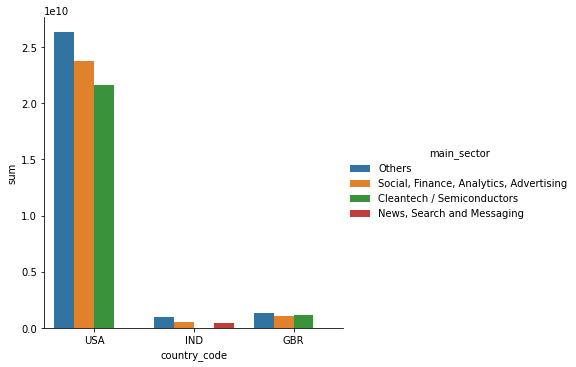

In [234]:
# sns.barplot(data=sectorwiseTop3.iloc[:,0:3],x="main_sector",y="country_code")
sns.catplot(x="country_code", y="sum", hue="main_sector", kind="bar", data=sectorwiseTop3.iloc[:,0:3])
plt.show()

<Figure size 792x504 with 0 Axes>

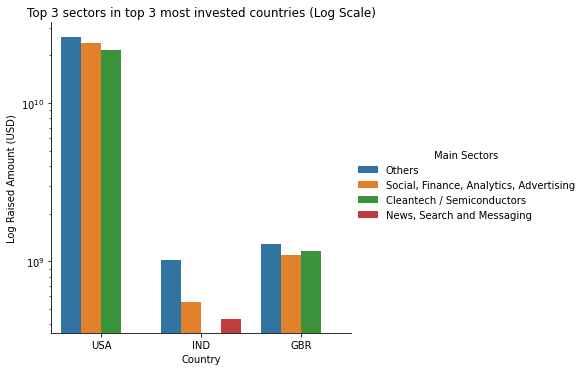

In [235]:
plt.figure(figsize=[11,7])

g=sns.catplot(x="country_code", y="sum", hue="main_sector", kind="bar", data=sectorwiseTop3.iloc[:,0:3])

g.fig.get_axes()[0].set_yscale('log')  ## Changing to log scale
g.set(xlabel = "Country", ylabel='Log Raised Amount (USD)')
g._legend.set_title("Main Sectors")
plt.title("Top 3 sectors in top 3 most invested countries (Log Scale)")
plt.show()

Total number of investments in the countries

In [236]:
print("USA\n",stats.loc["USA",:].sum(),"\n\n")
print("GBR\n",stats.loc["GBR",:].sum(),"\n\n")
print("IND\n",stats.loc["IND",:].sum(),"\n\n")


USA
 sum     107,757,097,294.00
count            12,063.00
dtype: float64 


GBR
 sum     5,379,078,691.00
count             621.00
dtype: float64 


IND
 sum     2,949,543,602.00
count             328.00
dtype: float64 




Companies with highest investment

In [237]:
print("USA:\n",D1.loc[D1["main_sector"]=="Others",["name","raised_amount_usd"]].groupby("name").agg(["sum","count"])["raised_amount_usd"].sort_values("sum",ascending=False))
print("\n\n\n",D1.loc[D1["main_sector"]=="Social, Finance, Analytics, Advertising",["name","raised_amount_usd"]].groupby("name").agg(["sum","count"])["raised_amount_usd"].sort_values("sum",ascending=False))

USA:
                               sum  count
name                                    
Virtustream         64,300,000.00      6
Capella Photonics   54,968,051.00      6
AirTight Networks   54,201,907.00      5
deCarta             52,100,000.00      5
Black Duck Software 51,000,000.00      6
...                           ...    ...
X-1                  5,000,000.00      1
Peatix               5,000,000.00      1
CashWorks            5,000,000.00      1
SynapticMash         5,000,000.00      1
CX                   5,000,000.00      1

[2049 rows x 2 columns]



                                           sum  count
name                                                
SST Inc. (Formerly ShotSpotter) 67,933,006.00      7
Demandbase                      63,000,000.00      5
Intacct                         61,800,000.00      5
NetBase Solutions               60,600,000.00      7
Lotame                          59,700,000.00      5
...                                       ...    ...
Bulldog 

In [238]:
print("GBR:\n",D2.loc[D2["main_sector"]=="Others",["name","raised_amount_usd"]].groupby("name").agg(["sum","count"])["raised_amount_usd"].sort_values("sum",ascending=False))
print("\n\n\n",D2.loc[D2["main_sector"]=="Social, Finance, Analytics, Advertising",["name","raised_amount_usd"]].groupby("name").agg(["sum","count"])["raised_amount_usd"].sort_values("sum",ascending=False))

GBR:
                                   sum  count
name                                        
Electric Cloud          37,000,000.00      4
SenSage                 36,250,000.00      4
Enigmatec               32,500,000.00      3
SilverRail Technologies 29,000,000.00      3
OpenCloud               27,972,766.00      3
...                               ...    ...
Bacula Systems           5,000,000.00      1
Vector Watch             5,000,000.00      1
The Filter               5,000,000.00      1
BullGuard                5,000,000.00      1
PhotoBox                 5,000,000.00      1

[120 rows x 2 columns]



                                 sum  count
name                                      
Celltick Technologies 37,500,000.00      4
myThings              34,000,000.00      4
Zopa                  32,900,000.00      3
VisualDNA             28,550,000.00      3
MarketInvoice         25,553,007.00      3
...                             ...    ...
The Fizzback Group     5,000,000.00  

In [239]:
print("IND:\n",D3.loc[D3["main_sector"]=="Others",["name","raised_amount_usd"]].groupby("name").agg(["sum","count"])["raised_amount_usd"].sort_values("sum",ascending=False))
print("\n\n\n",D3.loc[D3["main_sector"]=="Social, Finance, Analytics, Advertising",["name","raised_amount_usd"]].groupby("name").agg(["sum","count"])["raised_amount_usd"].sort_values("sum",ascending=False))

IND:
                             sum  count
name                                  
FirstCry.com      39,000,000.00      3
Myntra            38,000,000.00      4
CommonFloor       32,900,000.00      3
Pepperfry.com     28,000,000.00      3
ItzCash Card Ltd. 25,000,000.00      2
...                         ...    ...
Liases Foras       5,000,000.00      1
Ameyo              5,000,000.00      1
TastyKhana         5,000,000.00      1
Parcelled.in       5,000,000.00      1
Vedantu            5,000,000.00      1

[88 rows x 2 columns]



                                                          sum  count
name                                                               
Manthan Systems                                50,700,000.00      4
Komli Media                                    28,000,000.00      3
ShopClues.com                                  25,000,000.00      2
inTarvo                                        21,900,000.00      2
Grameen Financial Services                     21,55

##Conclusion



Spark funds can invest (as venture funding ) in companies in USA, Great Britain and India in sectors “Others” , “Cleantech / Semiconductors” , “Social, Finance, Analytics, Advertising” and “News, Search and Messaging”

Some of the companies are: Virtustream and SST Inc. (Formerly ShotSpotter) in USA, Electric Cloud and Celltick Technologies in Great Britain and FirstCry.com and Manthan Systems in India.
